# Hyper parameters

In [ ]:
INSTRUMENT = 'BTCUSDT'
# valid intervals - 1m, 3m, 5m, 15m, 30m, 1h, 2h, 4h, 6h, 8h, 12h, 1d, 3d, 1w, 1M
INTERVAL =  '30m'
INTERVALS_FUTURE = 50
INTERVALS_PAST = 100 # most important

HP_UNITS = 500
HP_LAYERS = 3

TRAIN_START = "2021-06-01"
TRAIN_END = "2021-09-01"

TEST_START = "2021-09-01"
TEST_END = "2021-10-01"

HP_DROPOUT = 0.5
HP_LR = 0.001
HP_BATCH_SIZE = 200
HP_EPOCHS = 350

labels = ['next1', 'next5', 'next10'] # most important

SPREAD = 0.00008 

INIT_DEPOSIT = 1000

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
%matplotlib inline
pd.set_option('mode.chained_assignment', None)

In [ ]:
!pip install python-binance

# Get Data

In [ ]:
import os
from binance.client import Client

client = Client('ECKmhCpRn2Wp3hL8J5ae6hIyXWl6nwMCInT8h4UI0dbUVeNngeyu9Zv7UAcOoBfs',
                '9pqP4wgHObK9W8WwUkT29zfTg8wZ1d84gAvnWwT8M6bHt4FY1ysFvNnTTMUZRh0P')


In [ ]:
from datetime import datetime

bars = client.get_historical_klines(INSTRUMENT, INTERVAL, TRAIN_START, TEST_END)

for line in bars:
    del line[2:]

data = pd.DataFrame(bars, columns=['Date', 'Price'])
data['Date'] = pd.to_datetime(data['Date'], unit='ms')
data['Price'] = pd.to_numeric(data['Price'])
data.set_index('Date', inplace=True)

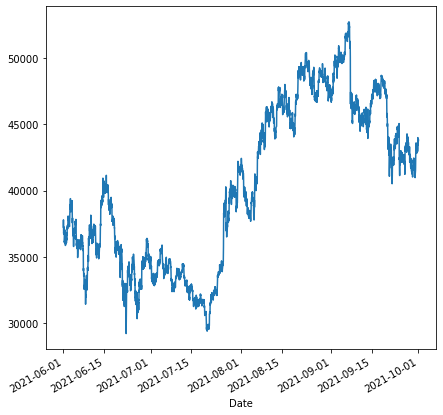

In [ ]:
data['Price'].plot(figsize=(7, 7))


# Create features

In [ ]:
for i in range(1, INTERVALS_PAST):
    data['prev' + str(i)] = np.log(data['Price'] / data['Price'].shift(i))

In [ ]:
for i in range(1, INTERVALS_FUTURE):
    data['next' + str(i)] = np.log(data['Price'] / data['Price'].shift(-i))

In [ ]:
data.dropna(inplace=True)

# Split to train set and test set

In [ ]:
import tensorflow as tf

In [ ]:
X_train = data.loc[(data.index >= TRAIN_START) & (data.index <= TRAIN_END)]
X_test = data.loc[(data.index >= TEST_START) & (data.index <= TEST_END)]

In [ ]:
y_train = X_train[labels].to_numpy()  # X - source, y - target
y_test = X_test[labels].to_numpy()

In [ ]:
columns = []
for i in range(1, INTERVALS_PAST):
    columns.append('prev' + str(i))

In [ ]:
X_train = X_train[columns].to_numpy()
X_test_times = X_test.index
X_test_price = X_test['Price'].to_numpy()
X_test = X_test[columns].to_numpy()

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices(((X_train), y_train))
train_ds = train_ds.take(len(X_train))
test_ds = tf.data.Dataset.from_tensor_slices(((X_test), y_test))
test_ds = test_ds.take(len(X_test))
train_ds = train_ds.batch(HP_BATCH_SIZE, False).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(len(X_test), False).prefetch(tf.data.AUTOTUNE)

In [ ]:
X_train.shape

(4309, 99)

In [ ]:
X_test.shape

(1388, 99)

# Training model

In [ ]:
# create an MLP model
def create_model(input_shape, output_shape):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units=HP_UNITS,
              activation='relu', input_shape=input_shape))
    for a in range(HP_LAYERS):
        model.add(tf.keras.layers.Dense(units=HP_UNITS, activation='relu'))
        if a != HP_LAYERS:
            model.add(tf.keras.layers.Dropout(HP_DROPOUT))

    model.add(tf.keras.layers.Dense(units=output_shape, activation='linear'))
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(
        HP_LR), metrics=["accuracy"])
    return model

In [ ]:
model = create_model(X_test[0].shape, len(y_test[0]))


In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=HP_BATCH_SIZE, verbose=0, epochs=HP_EPOCHS)

In [ ]:
# helper functions to plot accuracy and loss
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [ ]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

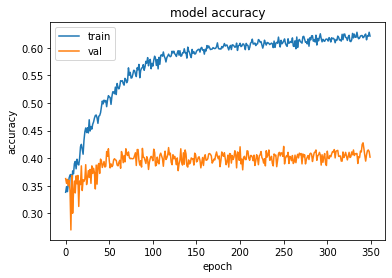

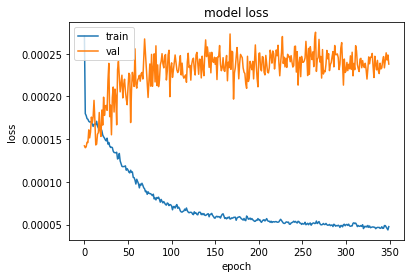

In [ ]:
plot_accuracy(history)
plot_loss(history)

# Train results

In [ ]:
train_prediction = model.predict(X_train)

In [ ]:
from sklearn.metrics import mean_absolute_error

train_mse = mean_absolute_error(y_train, train_prediction)
round(train_mse, 5)


0.00433

In [ ]:
for i in range(len(labels)):
    print (labels[i],   "{:8.5f}".format(mean_absolute_error(y_train[:,i], train_prediction[:,i])))  

next1  0.00367
next5  0.00503
next10  0.00429


In [ ]:
best = 0

for j in range(len(labels)):
    c = 0
    n = 0
    for i in range(len(y_train)):
        if abs(train_prediction[i, j]) < 0.00001:
            continue
        n = n+1
        if (np.sign(y_train[i, j]) == np.sign(train_prediction[i, j])):
            c = c+1
    print(labels[j], round(c/n, 3))
    if c/n > best:
        best = c/n
        best_label = j

labels[best_label]

next1 0.606
next5 0.797
next10 0.904


'next10'

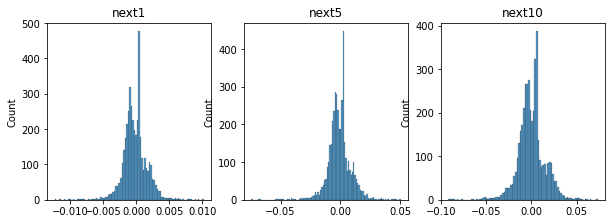

In [ ]:
import seaborn as sns

fig = plt.figure(figsize=(10,15))

for i in range(min(len(labels),12)):
    fig.add_subplot(4, 3, i+1)
    plt.title(labels[i])
    sns.histplot(data=train_prediction[:, i])


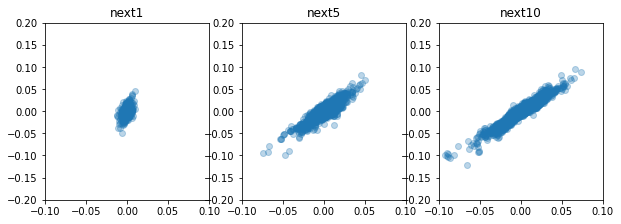

In [ ]:
fig = plt.figure(figsize=(10,15))

for i in range(min(len(labels),12)):
    fig.add_subplot(4, 3, i+1)
    plt.title(labels[i])

    plt.xlim(-0.1, 0.1)
    plt.ylim(-0.2, 0.2)
    plt.scatter(train_prediction[:, i], y_train[:, i], alpha=0.3)


# Test results

In [ ]:
test_prediction=model.predict(X_test)

In [ ]:
best = 0

for j in range(len(labels)):
    c = 0
    n = 0
    for i in range(len(y_test)):
        if abs(test_prediction[i, j]) < 0.00001:
            continue
        n = n+1
        if (np.sign(y_test[i, j]) == np.sign(test_prediction[i, j])):
            c = c+1
    print(labels[j], round(c/n, 3))
    if c/n > best:
        best = c/n
        best_label = j

labels[best_label]


next1 0.501
next5 0.529
next10 0.531


'next10'

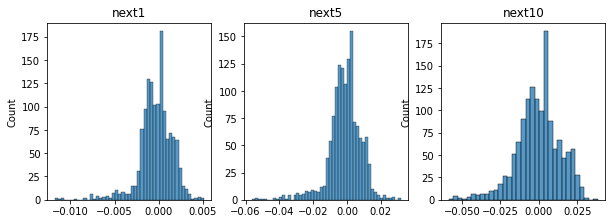

In [ ]:
import seaborn as sns

fig = plt.figure(figsize=(10,15))

for i in range(min(len(labels),12)):
    fig.add_subplot(4, 3, i+1)
    plt.title(labels[i])
    sns.histplot(data=test_prediction[:, i])


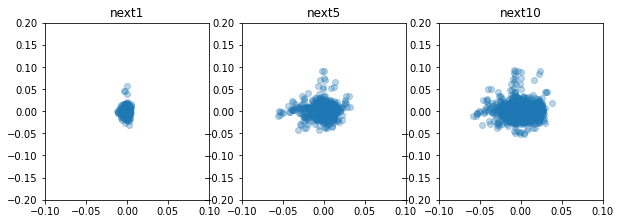

In [ ]:
fig = plt.figure(figsize=(10,15))

for i in range(min(len(labels),12)):
    fig.add_subplot(4, 3, i+1)
    plt.title(labels[i])
    plt.xlim(-0.1, 0.1)
    plt.ylim(-0.2, 0.2)
    plt.scatter(test_prediction[:, i], y_test[:, i], alpha=0.3)


# Backtesting

In [ ]:
summer = lambda y: sum(y)/len(labels)
test_sum = np.array([summer(y) for y in test_prediction])

In [ ]:
data = pd.DataFrame({'Datetime': X_test_times, 'distance': test_sum, 'Price': X_test_price })

In [ ]:
def run_strategy(a_data, threshold):
    ''' Backtests the trading strategy.
    '''
    data = a_data.copy().dropna()
    data['returns'] = np.log(data['Price'] / data['Price'].shift(1)).dropna()
    # buy BTC signals
    data['position'] = np.where(data['distance'] > threshold, 1, np.nan)
    # sell BTC signals
    data['position'] = np.where(data['distance'] < -threshold, -1,
                                data['position'])
    data['position'] = data['position'].ffill().fillna(0)
    data['strategy'] = data['position'].shift(1) * data['returns']
    # determine when a trade takes place
    trades = data['position'].diff().fillna(0) != 0
    # subtract transaction costs from return when trade takes place
    data['strategy'][trades] -= SPREAD
    data['buy'] = data['position'].diff().fillna(0) > 0
    data['sell'] = data['position'].diff().fillna(0) < 0
    data['creturns'] = INIT_DEPOSIT * data['returns'].cumsum().apply(np.exp)
    data['cstrategy'] = INIT_DEPOSIT * data['strategy'].cumsum().apply(np.exp)
    results = data
    # absolute performance of the strategy
    aperf = results['cstrategy'].iloc[-1]
    # base instrument performance (BTC)
    bperf = results['creturns'].iloc[-1]
    # out-/underperformance of strategy
    operf = aperf - bperf

    return round(aperf, 2), round(operf, 2), results

In [ ]:
best_threshold = 0
best_aperf = 0
for i in range(30):
    x, y, z = run_strategy(data, i/1000)
    print(i/1000, x)
    if x > best_aperf:
        best_aperf = x
        best_threshold = i/1000

0.0 1127.99
0.001 1199.25
0.002 1196.24
0.003 1259.36
0.004 1166.63
0.005 1121.74
0.006 1184.59
0.007 878.01
0.008 891.07
0.009 967.02
0.01 806.95
0.011 1052.52
0.012 968.99
0.013 872.82
0.014 1023.97
0.015 1001.18
0.016 1109.77
0.017 1118.95
0.018 1125.43
0.019 1034.45
0.02 1033.58
0.021 1033.58
0.022 1083.56
0.023 1079.28
0.024 1079.28
0.025 1079.28
0.026 1111.79
0.027 1111.94
0.028 1111.94
0.029 1111.94


In [ ]:
results=run_strategy(data, best_threshold)
print(results[0], results[1])
results = results[2]

1259.36 380.19


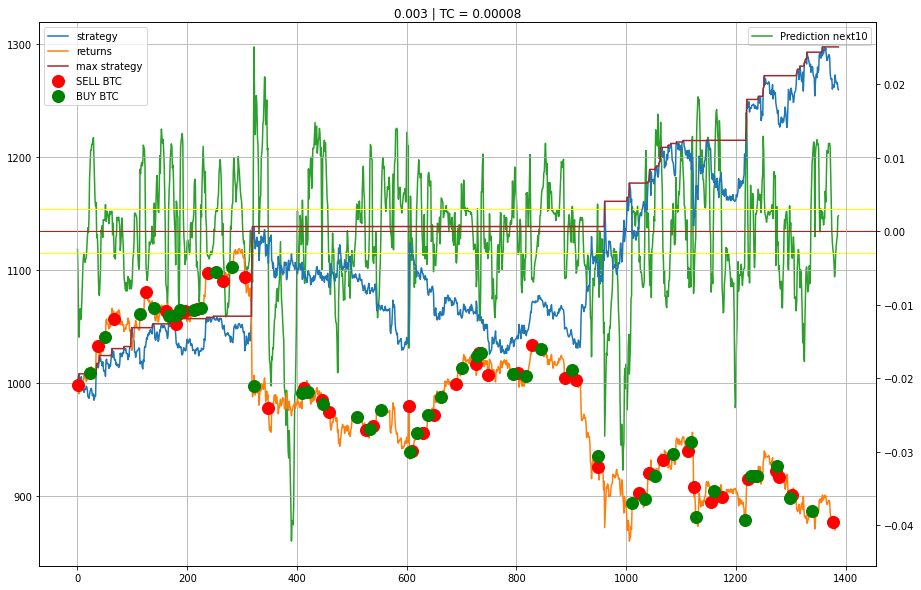

In [ ]:
results['mstrategy'] = results['cstrategy'].cummax()
fig, ax = plt.subplots(figsize=(15, 10))
plt.title('%s | TC = %.5f' % (best_threshold, SPREAD))
ax.plot( results.cstrategy, label='strategy')
ax.plot(results.creturns, color='tab:orange', label='returns')
ax.plot(results.mstrategy, label='max strategy', color='brown')
ax2 = ax.twinx()
ax2.plot(results.distance, color='tab:green', label="Prediction " + labels[best_label])
ax2.axhline(y=best_threshold, linewidth=1, color='yellow')
ax2.axhline(y=-best_threshold, linewidth=1, color='yellow')
ax2.axhline(0, linewidth=1, color='red')
ax2.set_zorder(-100)
ax.set_facecolor("none")
ax.plot(results.creturns.loc[results.sell], "ro", markersize=12, label='SELL BTC')  #RED - SELL BTC in high peak (BTC high, USD low) DX -
ax.plot(results.creturns.loc[results.buy], "go", markersize=12, label='BUY BTC')  #GREEN - BUY BTC in low peak (BTC low, USD high) DX +
ax.grid(True)
ax.legend(loc="upper left")
plt.legend()
plt.show()

# Kelly & Drowdown

In [ ]:
annual = np.exp(results[['returns', 'strategy']].mean() * 2 * 24  * 365) - 1
round(annual * 100)

returns      -80.0
strategy    1741.0
dtype: float64

In [ ]:
mean = results[['returns', 'strategy']].mean() 
var = results[['returns', 'strategy']].var() 
vol = var**0.5

In [ ]:
print("Kelly")
round(mean / var)

Kelly


returns    -3.0
strategy    6.0
dtype: float64

In [ ]:
drawdown = results['mstrategy'] - results['cstrategy']

In [ ]:
print("Max Drowdown ",round(drawdown.max() / 10, 2), '%')

Max Drowdown  11.29 %


# Algo

In [ ]:
STOP_LOSS = 0.0020
TAKE_PROFIT = 0.0020

In [ ]:
import os
from binance.client import Client

binance_key = 'N3QgtQuNWffffSSKFiGvuoQt8ha6nA1p8ZxXyA9ZuX4WZIU1Az1rESluIKuIrV46'
binance_secret = 'Ybausov6wPrZ8z0vkE5JDm0cc0GfK03vEmwapZUi4U94nWqD2wWiop4thsbBytAa'

client = Client(binance_key, binance_secret)

client.API_URL = 'https://testnet.binance.vision/api'

In [ ]:
import plotly.graph_objects as go  
from datetime import datetime, timedelta

fig = go.FigureWidget()
fig.add_scatter(name='NN')
fig.add_scatter(yaxis='y2', name='FX')
fig.layout.update(yaxis2=go.layout.YAxis(overlaying='y', side='right'))
fig.add_shape(type='line', x0=datetime.now() - timedelta(hours=6), y0=best_threshold,
              x1=datetime.now() + timedelta(hours=24), y1=best_threshold,
              line=dict(color='Green',), xref='x', yref='y')
fig.add_shape(type='line', x0=datetime.now() - timedelta(hours=6), y0=-best_threshold,
              x1=datetime.now() + timedelta(hours=24), y1=-best_threshold,
              line=dict(color='Green',), xref='x', yref='y')
fig.layout.template = "plotly_dark"
fig

FigureWidget({
    'data': [{'name': 'NN', 'type': 'scatter', 'uid': '09ff4d4c-1a93-4736-b78c-a5432d558147'},
…

In [ ]:
from datetime import datetime


def create_orders():
    global position
    global thresholds
    t, _, _ = calc_threshold()
    p(str(datetime.now()) + " " + str("{:.6f}".format(t)))
    times.append(datetime.now())
    signals.append(t)
    fxtimes.append(fx.iloc[0].name)
    fxclose.append(fx.iloc[0]["Close"])
    fig.data[0].x = times
    fig.data[0].y = signals
    fig.data[1].x = fxtimes
    fig.data[1].y = fxclose
    order = {}
    price = fx.iloc[0]["Close"]

    if t > THRESHOLD: 
        p("BUY BTC")
        get_position()
        if position == 0:
            client.create_order(symbol='BTCUSDT', side='BUY', type='MARKET', quantity=INIT_DEPOSIT)

        elif position == -1:
            client.create_order(symbol='BTCUSDT', side='BUY', type='MARKET', quantity=INIT_DEPOSIT*2)
        position = 1

    elif t < -THRESHOLD:
        p("SELL BTC")
        get_position()
        if position == 0:
            client.create_order(symbol='BTCUSDT', side='SELL', type='MARKET', quantity=INIT_DEPOSIT)
        elif position == 1:
            client.create_order(symbol='BTCUSDT', side='SELL', type='MARKET', quantity=INIT_DEPOSIT*2)
        position = -1


In [ ]:
import time

starttime = time.time()
while True:
    try:
        update_data()
    except Exception as e:
        p("Exception", logging.WARNING)
        p(e, logging.WARNING)

    create_orders()
    time.sleep(60.0 - ((time.time() - starttime) % 60.0))

In [ ]:
client.create_order(symbol='BTCUSDT', side='SELL', type='MARKET', quantity=1)


In [ ]:
client.get_asset_balance(asset='BTC')